# Install and Import libraries 📚 

In [3]:
# Import Torch Library
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models

# Import Required packages
import pickle
import zipfile 
import urllib
import skimage.io as io 
import numpy as np 
from PIL import Image
from tqdm import tqdm
from collections import Counter
!pip install nltk
import nltk
import os.path
import os 
import math
import sys
import random
import json
nltk.download('punkt')
from collections import Counter

# Import Google Drive & Mount 
from google.colab import drive 
drive.mount('/content/drive')
os.makedirs('opt', exist_ok=True)
os.chdir('/content/opt')

# Import COCO dataset
!git clone 'https://github.com/cocodataset/cocoapi.git'

import matplotlib.pyplot as plt 
%matplotlib inline 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'cocoapi' already exists and is not an empty directory.


# Install pycocotools 🥥🛠¶

In [4]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download dataset and its annotation (Caption)

In [5]:
os.chdir('/content/opt/cocoapi')

annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014, filename = 'annotations_trainval2014.zip')
urllib.request.urlretrieve(image_info_test2014, filename= 'image_info_test2014.zip')

with zipfile.ZipFile('annotations_trainval2014.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/opt/cocoapi')  
    os.remove('annotations_trainval2014.zip')
    print('zip removed')

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
    zip_ref.extractall('/content/opt/cocoapi')  
    os.remove('image_info_test2014.zip')
    print('zip removed')

os.chdir('/content/opt/cocoapi/annotations')

coco = COCO("instances_val2014.json")
coco_caps = COCO("captions_val2014.json")

ids = list(coco.anns.keys())

os.chdir('/content/opt/cocoapi')

urllib.request.urlretrieve('http://images.cocodataset.org/zips/train2014.zip', 'train2014')
urllib.request.urlretrieve('http://images.cocodataset.org/zips/test2014.zip', 'test2014')
#urllib.request.urlretrieve(val2014, 'val2014')

os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile('train2014', 'r') as zip_ref:
    zip_ref.extractall('images')
    os.remove('train2014')
    print('zip removed')

os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile('test2014', 'r') as zip_ref:
    zip_ref.extractall('images')
    os.remove('test2014')
    print('zip removed')

zip removed
zip removed
loading annotations into memory...
Done (t=11.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
zip removed
zip removed


# Showing One Sample 

Number of annotations i.e captions for the image:  [179763, 179784, 183348, 185466, 190887]
A computer is sitting on a desk with books.
An open laptop sits in front of a bookshelf.
A desk and bookshelf with a laptop computer, various books and a desk light.
A cluttered desk with a laptop computer turned on.
A computer is left on in front of a bookshelf


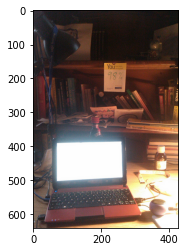

In [6]:
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
I = io.imread(url)
plt.imshow(I)

ann_ids = coco_caps.getAnnIds(img_id)
print('Number of annotations i.e captions for the image: ', ann_ids)
anns = coco_caps.loadAnns(ann_ids)
coco_caps.showAnns(anns)

## Define Word Embedding Class

In [7]:
class WordEmbedd(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):

        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

## Create Dataset Class

In [8]:
class COCO_Dataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = WordEmbedd(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            return image, caption

        else:
            path = self.paths[index]

            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

## Dataloader

In [9]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):

    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    dataset = COCO_Dataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        indices = dataset.get_train_indices()
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader


# Making Dataset Iterable

In [10]:
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

vocab_threshold = 8

batch_size = 200

data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:39<00:00, 10572.15it/s]


# Showing On Caption For Image

In [11]:
sample_caption = 'A person doing a trick xxxx on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize( sample_caption.lower() )

sample_caption = []
start_word = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word
sample_tokens.insert(0 , start_word)
sample_tokens.append(end_word)
sample_caption.extend([data_loader_train.dataset.vocab(token) for token in sample_tokens])


sample_caption = torch.Tensor(sample_caption).long()
print('Find Below the Sample tokens and the idx values of those tokens in word2idx' , '\n')
print(sample_tokens) 
print(sample_caption)

print('Find index values for words below \n')
print('Start idx {} , End idx {} , unknown idx {}'.format(0,1,2))

print('First few vocab', dict(list(data_loader_train.dataset.vocab.word2idx.items())[:10]))
print('Total number of tokens in vocabulary:', len(data_loader_train.dataset.vocab))

Find Below the Sample tokens and the idx values of those tokens in word2idx 

['<start>', 'a', 'person', 'doing', 'a', 'trick', 'xxxx', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '<end>']
tensor([  0,   3,  97, 744,   3, 393,   2,  38,   3, 993, 205, 137,   3, 743,
         18,   1])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2
First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 7072


## Use the Data Loader to Obtain Batches with the Same Length

In [12]:
counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted(counter.items(), key = lambda pair : pair[1], reverse=True)
for val,count in lengths:
    print('Caption Length: %2d  Count %5d' %(val,count))
    if count < 10000: 
        break

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
# print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images, captions = next(iter(data_loader_train))
# print(images.shape, captions.shape)

Caption Length: 10  Count 86302
Caption Length: 11  Count 79971
Caption Length:  9  Count 71920
Caption Length: 12  Count 57653
Caption Length: 13  Count 37668
Caption Length: 14  Count 22342
Caption Length:  8  Count 20742
Caption Length: 15  Count 12839
Caption Length: 16  Count  7736


## Define Encoder Network 
> 

In [13]:
class EncoderNet(nn.Module):
    def __init__(self, embed_size):
        super(EncoderNet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features

## Define Hyperparameter For Encoder Network 

In [14]:
# specify dim of image embedding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256 
encoder = EncoderNet(embed_size)
encoder.to(device)
images = images.to(device) # images from step2 
features = encoder(images)

print(type(features), features.shape, images.shape)
assert( type(features) == torch.Tensor ), 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size), "The shape of the encoder output is incorrect."

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<class 'torch.Tensor'> torch.Size([200, 256]) torch.Size([200, 3, 224, 224])


## Define Decoder Network
> 

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm  = nn.LSTM(input_size=self.embed_size, 
                             hidden_size=self.hidden_size,
                             num_layers=self.num_layers,
                             batch_first=True 
                             )
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
        

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
        torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
    
    def forward(self, features, captions):            
        captions = captions[:,:-1]      
        self.batch_size = features.shape[0]
        self.hidden = self.init_hidden(self.batch_size)
        embeds = self.word_embedding(captions)
        inputs = torch.cat((features.unsqueeze(dim=1), embeds), dim=1)      
        lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
        outputs = self.fc(lstm_out)      
        return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

## Instatiate Model & Optimizer Class

In [16]:
embed_size = 256
hidden_size = 100
vocab_size = len(data_loader_train.dataset.vocab)
num_layers = 1 

decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

num_epochs = 2
print_every = 200

total_step = math.ceil(len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size)

criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params=all_params, lr=lr)

## Training *Process*

In [17]:
for e in range(num_epochs):
    for step in range(total_step):
        indices = data_loader_train.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices)
        data_loader_train.batch_sampler.sampler = new_sampler    
        images, captions = next(iter(data_loader_train))    
        images, captions = images.to(device), captions.to(device)
        encoder, decoder = encoder.to(device), decoder.to(device)
        encoder.zero_grad()    
        decoder.zero_grad()
        features = encoder(images)
        output = decoder(features, captions)    
        loss = criterion(output.view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()
        stat_vals = 'Epochs [%d/%d], Step [%d/%d], Loss [%.4f]' %( e+1,num_epochs,step,total_step,loss.item())
        if step % print_every == 0:
            print(stat_vals)
            sys.stdout.flush()


Epochs [1/2], Step [0/2071], Loss [8.8726]
Epochs [1/2], Step [200/2071], Loss [3.8858]
Epochs [1/2], Step [400/2071], Loss [3.5302]
Epochs [1/2], Step [600/2071], Loss [3.2635]
Epochs [1/2], Step [800/2071], Loss [3.1594]
Epochs [1/2], Step [1000/2071], Loss [3.4171]
Epochs [1/2], Step [1200/2071], Loss [3.3260]
Epochs [1/2], Step [1400/2071], Loss [2.9113]
Epochs [1/2], Step [1600/2071], Loss [3.1247]
Epochs [1/2], Step [1800/2071], Loss [2.8432]
Epochs [1/2], Step [2000/2071], Loss [3.1300]
Epochs [2/2], Step [0/2071], Loss [2.6249]
Epochs [2/2], Step [200/2071], Loss [2.4140]
Epochs [2/2], Step [400/2071], Loss [2.5153]
Epochs [2/2], Step [600/2071], Loss [2.5142]
Epochs [2/2], Step [800/2071], Loss [2.4785]
Epochs [2/2], Step [1000/2071], Loss [2.5880]
Epochs [2/2], Step [1200/2071], Loss [2.5129]
Epochs [2/2], Step [1400/2071], Loss [2.4073]
Epochs [2/2], Step [1600/2071], Loss [2.7630]
Epochs [2/2], Step [1800/2071], Loss [2.5411]
Epochs [2/2], Step [2000/2071], Loss [2.5033]


## Training *Process*

Vocabulary successfully loaded from vocab.pkl file!


'a train is traveling down the tracks near a building .'

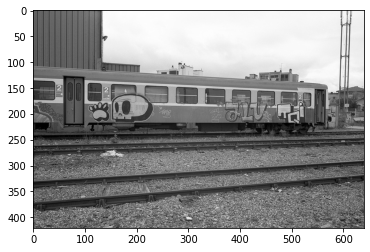

In [18]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content/opt')

data_iter = iter(data_loader_test)

def get_sentences(original_img, all_predictions):
    sentence = ' '
    plt.imshow(original_img.squeeze())
    return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1]])

encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img, processed_img = next(data_iter)

features = encoder(processed_img.to(device)).unsqueeze(1)
final_output = decoder.Predict(features, max_len=20)
get_sentences(original_img, final_output)